In [1]:
!date

Fri Oct 30 17:01:59 PDT 2020


# Splitting clusters on isoforms

In [1]:
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from scipy import stats
import os
import anndata
import matplotlib.transforms as transforms
import glob
import sys
def nd(arr):
    return np.asarray(arr).reshape(-1)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [3]:
num_TSNE = 2
state = 42
metric = "euclidean"
n_neighbors = 30
num_PCA = 25
num_NCA = 10

# Filtering criteria
cell_threshold = 250
disp_threshold = 0.001

mito_criteria = 10

n_top_genes = 5000

n_bins = 20

flavor="seurat"

scale_clip = 10

In [4]:
import ast

In [5]:
gene = anndata.read_h5ad("../../data/notebook/revision/gene.h5ad")
isoform = anndata.read_h5ad("../../data/notebook/revision/isoform.h5ad")

In [6]:
gene_id = gene.var["gene_id"].values
gene_names = gene.var["gene_name"].values.astype(str)

# Restrict to genes with more than one isoform

In [7]:
gene = gene[:,gene.var["num_isoforms"]>1]

In [8]:
%%time
transcripts = []
l = gene.var.txn_list.values
for sublist in l:
    sublist = ast.literal_eval(sublist)
    for item in sublist:
        transcripts.append(item)

CPU times: user 189 ms, sys: 2.22 ms, total: 191 ms
Wall time: 190 ms


In [9]:
isoform = isoform[:,isoform.var["transcript_id"].isin(transcripts)]

In [10]:
print(gene)
print(isoform)

View of AnnData object with n_obs × n_vars = 6160 × 11891
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'percent_mito', 'n_genes', 'pass_count_filter', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'txn_list', 'num_isoforms', 'gene_counts', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p', 'norm'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 6160 × 61873
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'gene_counts', 'high

# Cluster on the subclasses to see if there is an isoform that splits one 

In [11]:
from sklearn.cluster import KMeans

In [12]:
clusters = np.unique(isoform.obs.cluster_label.values)

In [13]:
%%time

# isoform level

files = []
for c in clusters:
    tmp = isoform[isoform.obs.eval(f"cluster_label== '{c}'")].copy()
    kmeans = KMeans(n_clusters=2, random_state=state).fit(tmp.X)
    tmp.obs["km"] = kmeans.labels_
    files.append(tmp)

CPU times: user 22min 27s, sys: 1min 44s, total: 24min 12s
Wall time: 1min 30s


In [14]:
new_isoform = files[0].concatenate(*files[1:])

# Plot new clusters

In [15]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

In [16]:
shape = np.round(np.sqrt(new_isoform.obs.cluster_label.nunique())).astype(int)
n_clusters = new_isoform.obs.cluster_label.nunique()

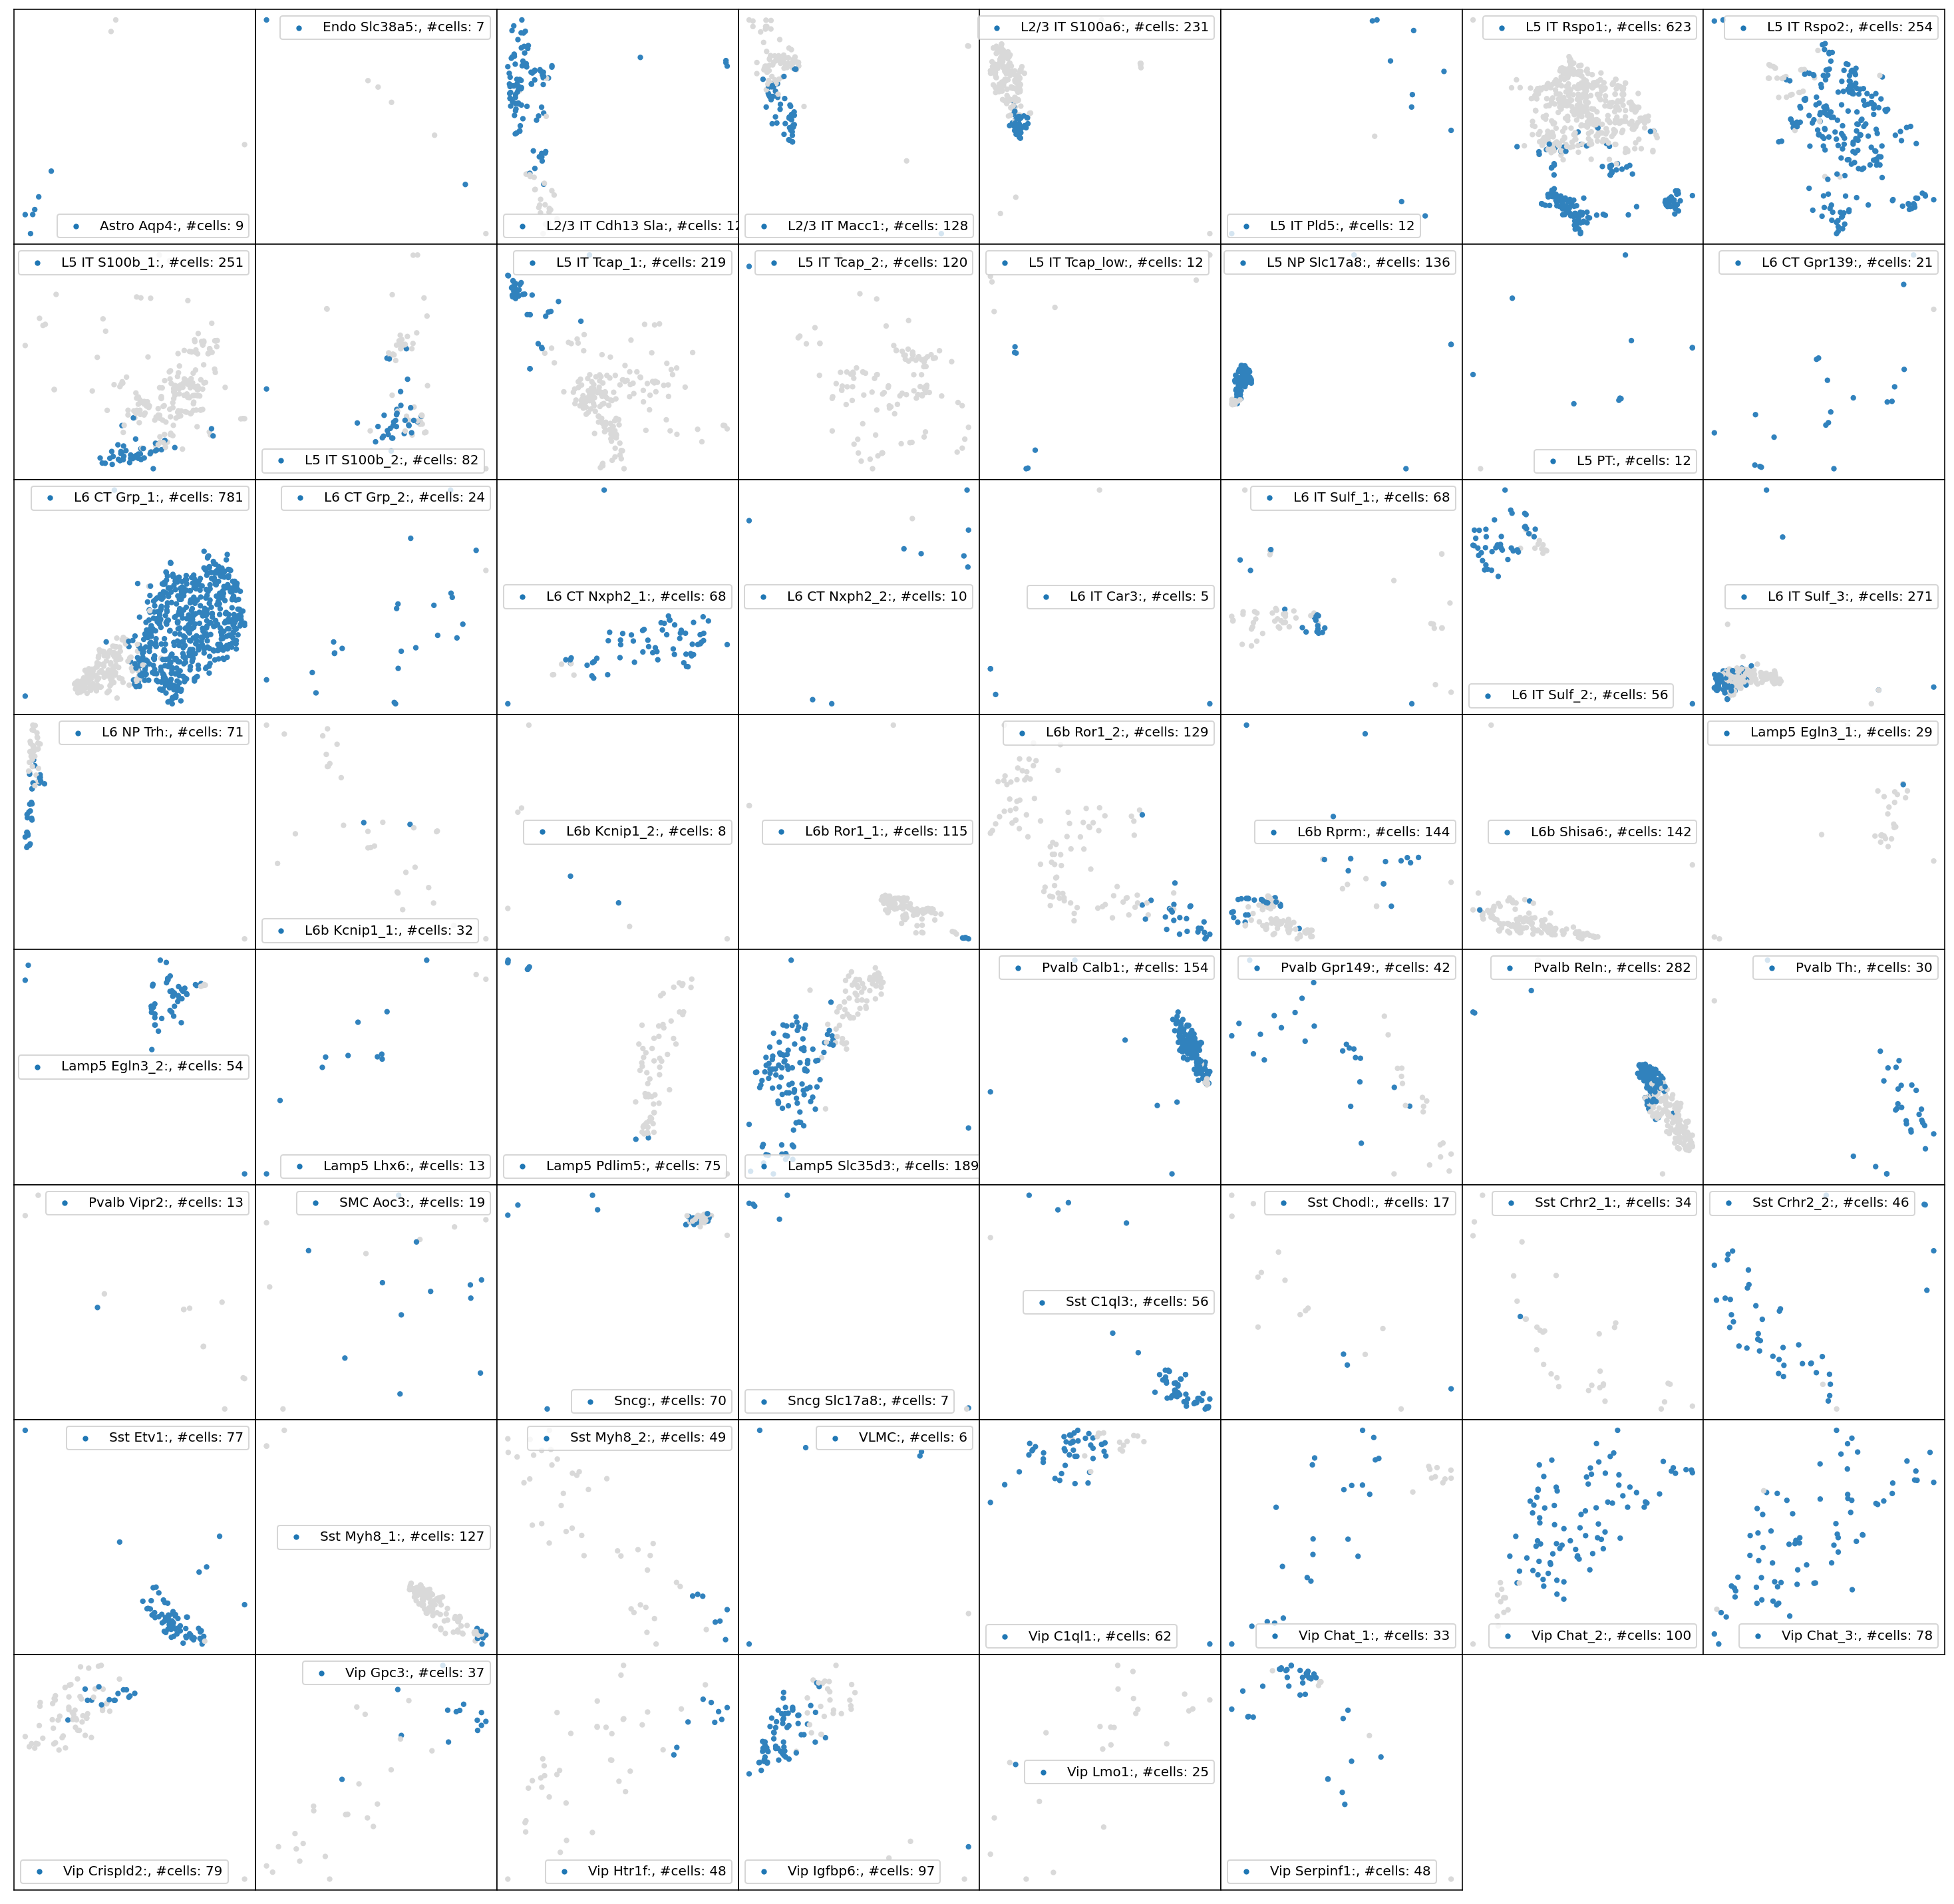

In [17]:
fig, ax = plt.subplots(figsize=(26,26), ncols=shape, nrows=shape)
fig.subplots_adjust(hspace=0, wspace=0)
axs = trim_axs(ax, n_clusters)


for sidx, (ax, cluster) in enumerate(zip(axs, clusters)):
    tmp = new_isoform[new_isoform.obs.eval(f"cluster_label == '{cluster}'")]

    ax = axs[sidx]
    XX = tmp.obsm["X_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    color = tmp.obs.km.astype(int)
    ax.scatter(x, y,s=10, c = color, cmap="tab20c", label=cluster+":, #cells: {:,}".format(x.shape[0]))# label=cluster+", #clusters {:,}".format(np.unique(color).shape[0]))
    ax.legend(fontsize=10)
    ax.set(**{
        "xticks": [],
        "xticklabels": [],
        "yticks": [],
        "yticklabels": [],
    })

fig.show()

In [18]:
gene.obs["km"] = new_isoform.obs.km.values

Trying to set attribute `.obs` of view, copying.


In [19]:
isoform = new_isoform[new_isoform.obs.eval("cluster_label == 'L6 CT Grp_1'")].copy()
gene = gene[gene.obs.eval("cluster_label == 'L6 CT Grp_1'")].copy()

In [20]:
isoform

AnnData object with n_obs × n_vars = 781 × 61873
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'leiden', 'louvain', 'km', 'batch'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'gene_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p', 'norm'

In [21]:
gene

AnnData object with n_obs × n_vars = 781 × 11891
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'percent_mito', 'n_genes', 'pass_count_filter', 'leiden', 'louvain', 'km'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'txn_list', 'num_isoforms', 'gene_counts', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p', 'norm'
    obsp: 'connectivities', 'distances'

# determine the isoforms

In [23]:
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ks_2samp, ttest_ind
import numpy as np
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')



def split_by_target(mat, targets, target, axis=0):
    """
    Split the rows of mat by the proper assignment
    
    mat = ndarray
    targets, length is equal to number of components (axis=0) or features (axis=1)
    target is a singular element from unique(assignments/features) 
    """
    if axis==0 and len(targets) != mat.shape[axis]: return -1
    if axis==1 and len(targets) != mat.shape[axis]: return -1
        
    mask = targets == target
    
    if axis==0:
        t_mat = mat[mask]  # target matrix
        c_mat = mat[~mask] # complement matrix
    elif axis==1:
        t_mat = mat[:, mask]  # target matrix
        c_mat = mat[:, ~mask] # complement matrix
    
    return (t_mat, c_mat)

def correct_pval(pval, method):
    nfeat = pval.shape[1]
    
    if method == 'benjamini-hochberg':
        _, pval_corr, _, _ = multipletests(pval, alpha=0.01, method='fdr_bh')
    elif method == 'bonferroni':
        pval_corr = np.minimum(pval*np.isnan(pval).sum(), 1.0)
        
    return pval_corr

# compute de
def dexpress(mat, components, features, assignments, **kwargs):
    """
    mat: ndarray
    components: nparray
    features: nparray
    assignments: nparray, length is equal to length of components
    """
    nan_cutoff = kwargs.get("nan_cutoff", 0)
    
    unique = np.unique(assignments)
        
    ncomp = components.shape[0]
    nfeat = features.shape[0]
    nuniq = unique.shape[0]
    
    pval = np.empty((nuniq, nfeat)) # unique assignments by features 
    pval_corr = np.empty((nuniq, nfeat)) # unique assignments by features 
    stat = np.empty((nuniq, nfeat)) # unique assignments by features 
    es = np.empty((nuniq, nfeat)) # unique assignments by features 
    
    pval.fill(np.nan)
    pval_corr.fill(np.nan)
    stat.fill(np.nan)

    for tidx, t in enumerate(unique):
        logging.info("{} of {} assignments: {}".format(tidx+1, nuniq, t))
        t_mat, c_mat = split_by_target(mat, assignments, t, axis=0)
        
        pvalue = np.nan
        statistic = np.nan
        effect_size = np.nan

        # Keep only the genes for which it is in at least nan_cutoff*ncellsinclusters
        mask = np.asarray((t_mat>0).sum(axis=0) > nan_cutoff*t_mat.shape[0]).reshape(-1)

        t_mat = t_mat[:, mask]
        c_mat = c_mat[:, mask]
        # added

        # added
        if mask.sum()>0:
            test = ttest_ind(t_mat, c_mat, nan_policy="propagate", equal_var=False)
            pvalue = test.pvalue
            statistic = test.statistic
            effect_size = nd(t_mat.mean(axis=0)) - nd(c_mat.mean(axis=0))
                
        pval[tidx,:][mask] = pvalue
        stat[tidx,:][mask] = statistic
        es[tidx,:][mask] = effect_size
    return (pval, stat, es)

def make_table(assignments, features, p_raw, p_corr, es):
    unique = np.unique(assignments)
    markers = pd.DataFrame(index=unique, columns=["name", "p_raw", "p_corr", "es"])

    for uidx, u in enumerate(unique):
        markers.loc[u]["name"] = features
        markers.loc[u]["p_raw"] = p_raw[uidx]
        markers.loc[u]["p_corr"] = p_corr[uidx]
        markers.loc[u]["es"] = es[uidx]

    markers = markers.apply(pd.Series.explode).reset_index()
    markers = markers[markers.notnull()["p_raw"]]
    return markers

def vplot(data, xlabels, ax):
    violins = ax.violinplot(data, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor('#D43F3A')
        v.set_edgecolor('black')
        v.set_alpha(1)
    
    for didx, d in enumerate(data):
        x = didx+1
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 2, color="grey")
        
        # mean and error bars
        mean = np.mean(d)
        print(mean)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean,color="black")    
        ax.vlines(x, mean - stdev, mean+stdev, color='black', linestyle='-', lw=2)
    
    return ax


In [24]:
%%time
# actual data GENE
mat           = gene.layers["log1p"].todense()
components    = gene.obs.cell_id.values
features      = gene.var.gene_name.values
assignments   = gene.obs.km.values

# parameters
unique        = np.unique(assignments)
nan_cutoff    = 0.90 # of elements in cluster
corr_method   = "bonferroni"

CPU times: user 43.3 ms, sys: 27.9 ms, total: 71.2 ms
Wall time: 68.6 ms


In [25]:
p_raw, stat, es = dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_corr = correct_pval(p_raw, corr_method)

s = stat

markers_gene = make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min

30-Oct-20 21:55:25 - 1 of 2 assignments: 0
30-Oct-20 21:55:25 - 2 of 2 assignments: 1


In [26]:
%%time
# actual data ISOFORM
mat           = isoform.layers["log1p"].todense()
components    = isoform.obs.cell_id.values
features      = isoform.var.transcript_name.values
assignments   = isoform.obs.km.values

# parameters
unique        = np.unique(assignments)
nan_cutoff    = 0.90 # of elements in cluster
corr_method   = "bonferroni"

CPU times: user 81.3 ms, sys: 207 ms, total: 289 ms
Wall time: 285 ms


In [27]:
p_raw, stat, es = dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_corr = correct_pval(p_raw, corr_method)

s = stat

markers_isoform = make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_isoform["p_corr"][markers_isoform.eval("p_corr == 0").values] = sys.float_info.min

30-Oct-20 21:55:28 - 1 of 2 assignments: 0
30-Oct-20 21:55:28 - 2 of 2 assignments: 1


# plotting isoforms and genes

In [28]:
def volcano(x, y, ax, alpha=0.01, fc=2):
    ymask = y < -np.log(alpha)
    xmask = np.abs(x) < np.log(fc)

    mask = np.logical_or(xmask, ymask)

    xx = x[mask]
    yy = y[mask] 
    ax.scatter(xx,yy, label="isoform", color="grey")

    xx = x[~mask]
    yy = y[~mask]
    ax.scatter(xx,yy, label="isoform", color="black")

    ax.axhline(y=-np.log(alpha), color="red", linestyle="--")
    ax.axvline(x=np.log(fc), color="red", linestyle="--")
    ax.axvline(x=-np.log(fc), color="red", linestyle="--")
    ax.set(**{
        "xscale": "symlog",
        "yscale": "symlog",
        "xlabel": "Cluster mean difference",
        "ylabel": "-log(p-value)",
        "ylim": (0),
        "xlim": (-np.max(np.abs(x))*1.5, np.max(np.abs(x))*1.5)
    })
    return ax

In [48]:
data = markers_isoform.query("index == 0")

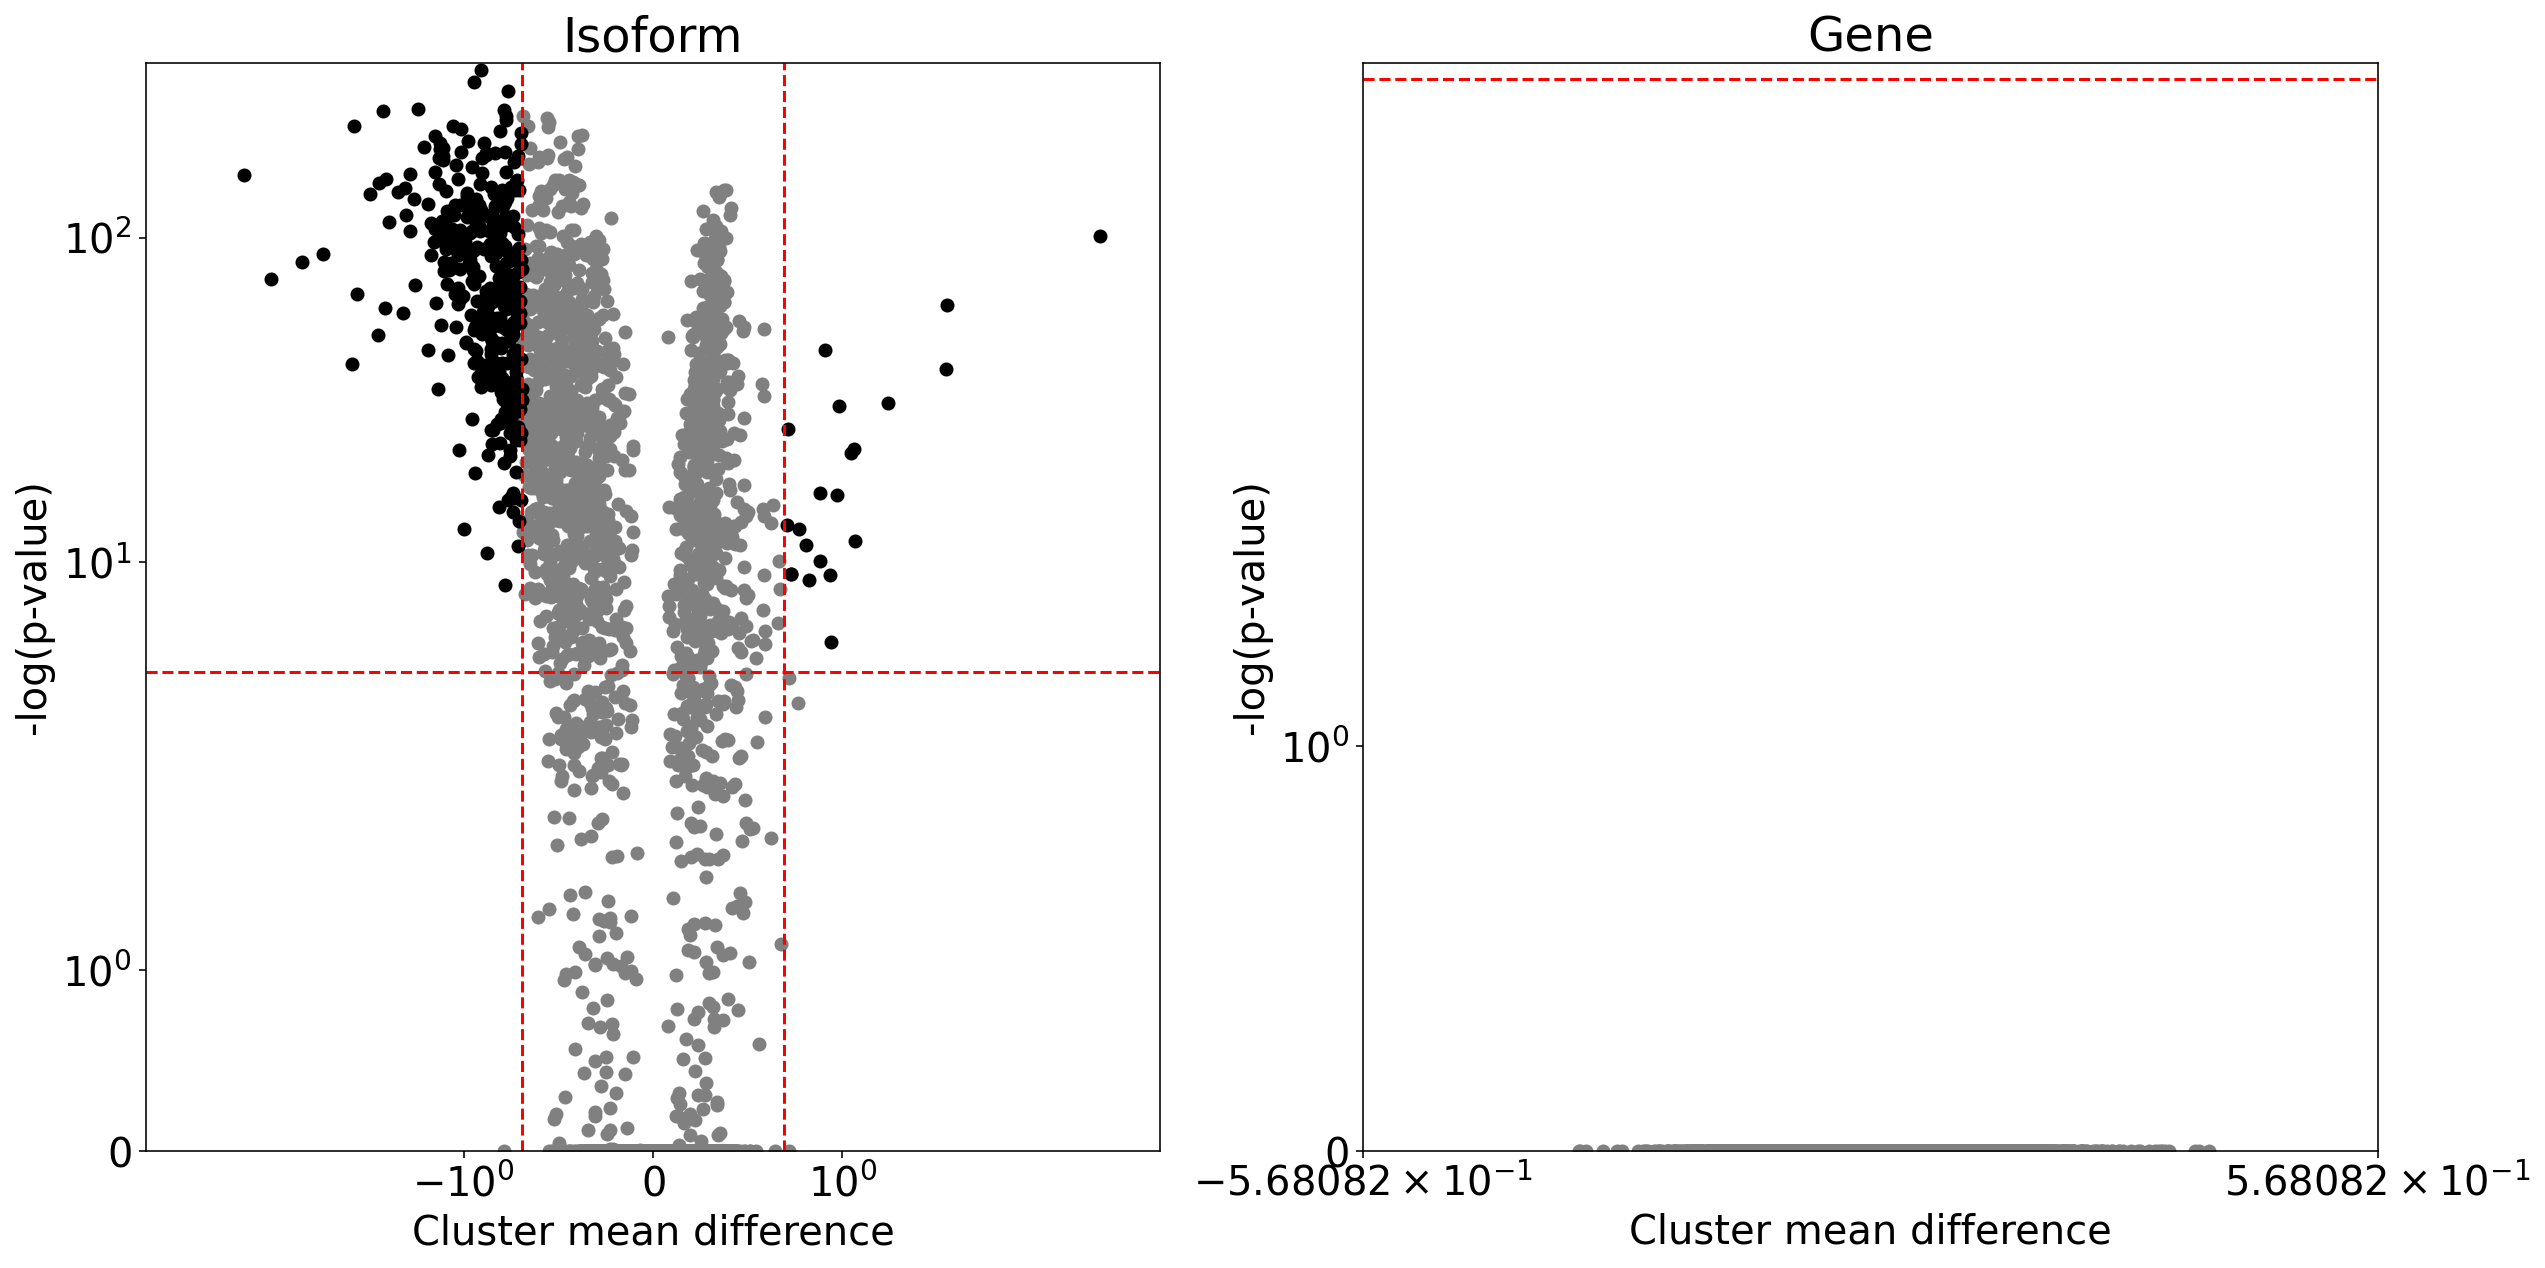

In [49]:
fig, ax = plt.subplots(figsize=(20,10), ncols=2)

x = data["es"].values.astype(float)
y = -np.log(data["p_corr"].values.astype(float))

volcano(x, y, ax[0])
ax[0].set_title("Isoform")

x = markers_gene["es"].values.astype(float)
y = -np.log(markers_gene["p_corr"].values.astype(float))

volcano(x, y, ax[1])
ax[1].set_title("Gene")

fig.show()

In [51]:
data.sort_values(["p_corr", "name"])

,index,name,p_raw,p_corr,es
40856,0,Pkm-202_ENSMUST00000163694,5.43964e-148,6.22186e-143,-0.910858
26974,0,Aplp1-201_ENSMUST00000006828,1.78297e-136,2.03936e-131,-0.945004
34894,0,Atp6v1b2-201_ENSMUST00000006435,8.64294e-129,9.88579e-124,-0.765233
56721,0,App-201_ENSMUST00000005406,9.44731e-114,1.08058e-108,-1.24233
57407,0,Ppp2r1a-201_ENSMUST00000007708,4.78848e-113,5.47707e-108,-0.786137
...,...,...,...,...,...
30307,0,Zranb1-202_ENSMUST00000106157,0.0311888,1,-0.171602
14147,0,Zranb2-202_ENSMUST00000106057,0.00240013,1,-0.343178
14143,0,Zranb2-203_ENSMUST00000106058,0.12938,1,-0.115775
10868,0,Zrsr2-201_ENSMUST00000090840,0.0467811,1,-0.127419


In [74]:
alpha = 0.01

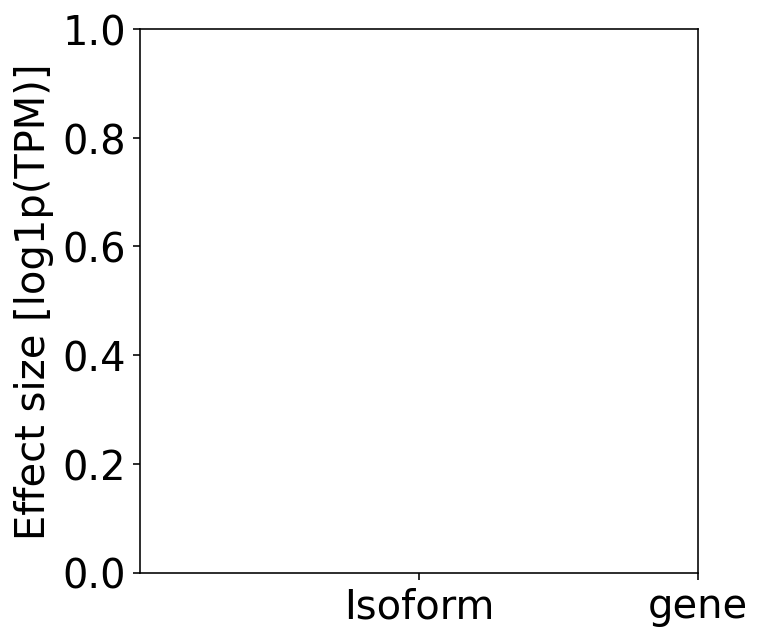

In [76]:
fig, ax = plt.subplots(figsize=(5,5))
labels = ["Isoform", "gene"]
lticks = np.arange(len(labels)) + 1
iso_mask = markers_isoform["p_corr"] < alpha
gen_mask = markers_gene["p_corr"] < alpha

data = [np.abs(markers_isoform["es"].values.astype(float))[iso_mask], np.abs(markers_gene["es"].values.astype(float))[gen_mask]]
#vplot(data, [], ax)

ax.set(**{
    "xticklabels": labels,
    "xticks": lticks,
    "ylabel": "Effect size [log1p(TPM)]"
 })

fig.show()

In [77]:
stats.ttest_ind(*data)

Ttest_indResult(statistic=nan, pvalue=nan)

# Set diff isoforms and genes

In [37]:
markers_isoform["gene"] = markers_isoform["name"].apply(lambda x: x.split("-")[0])

In [38]:
markers_gene["gene"] = markers_gene["name"].apply(lambda x: x.split("_")[0])

In [39]:
# want isoforms for which the gene is not differential
mask = markers_isoform.gene.isin(markers_gene.query(f"p_corr > {alpha}").gene.values)
markers_isoform[mask].sort_values("p_corr")

,index,name,p_raw,p_corr,es,gene
84279,1,Vps50-201_ENSMUST00000001412,6.81237e-41,3.84477e-36,1.57425,Vps50
114565,1,Zfp706-201_ENSMUST00000078976,2.43326e-40,1.37328e-35,0.388374,Zfp706
52692,0,Zfp706-201_ENSMUST00000078976,2.43326e-40,1.40988e-35,-0.388374,Zfp706
74595,1,Ensa-201_ENSMUST00000037983,3.167e-40,1.78739e-35,0.604839,Ensa
12722,0,Ensa-201_ENSMUST00000037983,3.167e-40,1.83502e-35,-0.604839,Ensa
...,...,...,...,...,...,...
50660,0,Dnajb9-201_ENSMUST00000015049,0.0314141,1,-0.128381,Dnajb9
50692,0,Nova1-201_ENSMUST00000021438,0.58718,1,0.033816,Nova1
50722,0,Ap4s1-201_ENSMUST00000021338,0.160133,1,0.0645817,Ap4s1
50752,0,Eapp-204_ENSMUST00000161592,0.00469767,1,0.161401,Eapp


# Plot the gene expression and the marker isoform expression

In [66]:
i = "Aplp1-201_ENSMUST00000006828"

In [67]:
g = gene.var[gene.var.gene_name.str.contains(f"{i.split('-')[0]}")].index.values[0]
print(g)

Aplp1_ENSMUSG00000006651


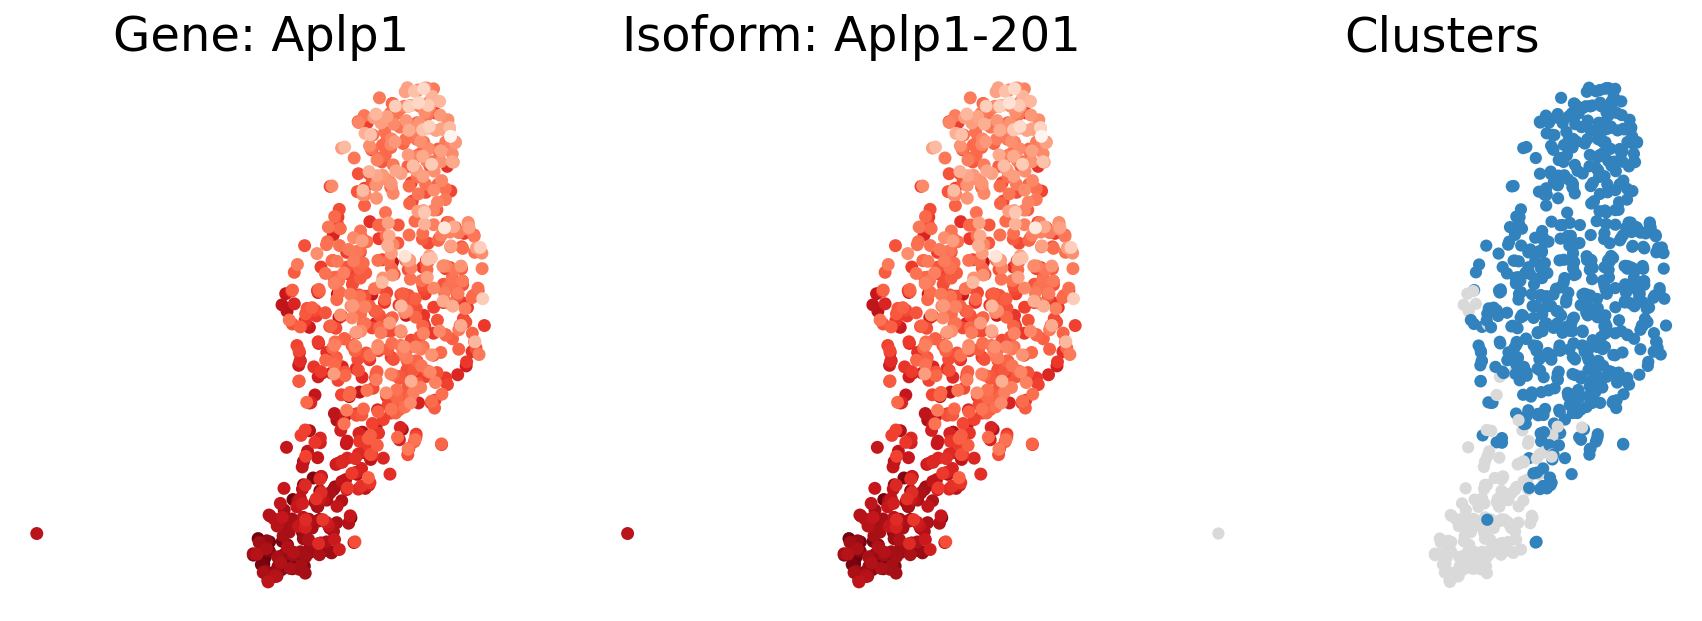

In [68]:
fig, axs = plt.subplots(figsize=(15, 5), ncols=3)

X = gene.obsm["X_nca_tsne"]

Yi = isoform.layers["log1p"][:, isoform.var.index.values == i]
Yg = gene.layers["log1p"][:, gene.var.index.values == g]
pt_size = 30

ax = axs[0] # gene

x = X[:,0]
y = X[:,1]
c = nd(Yg.todense())
argsort = np.argsort(c)[::-1]
x = x[argsort]
y = y[argsort]
c = c[argsort]

ax.scatter(x,y, c=c, cmap="Reds", s=pt_size)
ax.set_axis_off()
ax.set_title(f"Gene: {g.split('_')[0]}")


ax = axs[1] # isoform

x = X[:,0]
y = X[:,1]
c = nd(Yi.todense())
argsort = np.argsort(c)[::-1]
x = x[argsort]
y = y[argsort]
c = c[argsort]

ax.scatter(x,y, c=c, cmap="Reds", s=pt_size)
ax.set_axis_off()
ax.set_title(f"Isoform: {i.split('_')[0]}")

ax = axs[2] # clusters

x = X[:,0]
y = X[:,1]
c = isoform.obs.km.values

ax.scatter(x,y, c=c, cmap="tab20c", s=26)
ax.set_axis_off()
ax.set_title("Clusters")

#plt.savefig(f"../../figures/split_subclass_{i.split('_')[0]}.png",bbox_inches='tight', dpi=300)

fig.show()

6.240595382863843
6.200536903745747
6.007679398166901
6.952682995278294


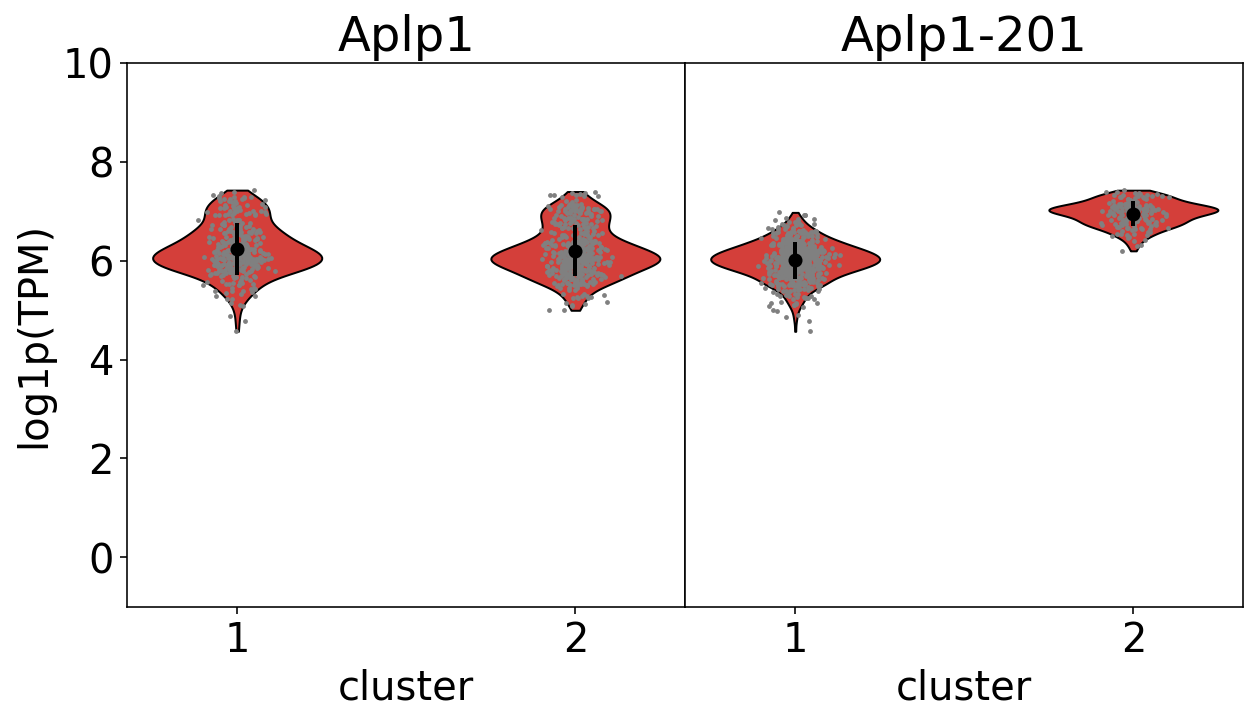

In [72]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

km = np.unique(isoform.obs.km.values)
iso_vector = nd(isoform.layers["log1p"][:, isoform.var.index.values == i].todense())
gene_vector = nd(gene.layers["log1p"][:, gene.var.index.values == g].todense())

lidx = np.arange(len(km)) + 1
labels = [f"{i}" for i in lidx]
kwd = {
    "xticks" : lidx,
    "xticklabels": labels,
    "xlabel":"cluster",
    "ylim": (-1, 10),
    "ylabel": "log1p(TPM)"
}

ax = axs[0]

mask = gene.obs.eval(f"km == '0'")
data = [gene_vector[mask], gene_vector[~mask]]

vplot(data, [], ax)
ax.set_title(f"{g.split('_')[0]}")
ax.set(**kwd)


ax = axs[1]
mask = isoform.obs.eval(f"km == '0'")
data = [iso_vector[mask], iso_vector[~mask]]

vplot(data, [], ax)

ax.set_title(f"{i.split('_')[0]}")
kwd["yticks"] = []
kwd["yticklabels"] = []
kwd["ylabel"] = ""
ax.set(**kwd)

fig.show()